In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

In [2]:
imgsize =128

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\GOKUL SHANMUGAM\\Downloads\\archive (2)\\TB_Chest_Radiography_Database\\tb.jpg",
    shuffle=True,
    image_size=(imgsize, imgsize),
    batch_size=4
)


Found 4200 files belonging to 2 classes.


In [4]:
clsname=dataset.class_names
clsname


['Normal', 'Tuberculosis']

In [5]:
def normalize_image(image, label):
    # Resize image to 128x128
    image = tf.image.resize(image, [imgsize,imgsize])
    return image / 255.0, label

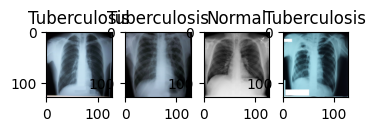

In [6]:
plt.figure(figsize=(10,10))
for images, labels in dataset.take(1):
     for i in range(4):
         plt.subplot(4,10,i+1)
         plt.imshow(images[i].numpy().astype("uint8"))
         plt.title(clsname[labels[i]])
         plt.axis=("off")



In [7]:
len(dataset)

1050

In [8]:
# Calculate the dataset size
dataset_size = dataset.cardinality().numpy()

# Define the split sizes
train_size = int(0.7 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = int(0.1 * dataset_size)

# Create train, validation, and test datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)


In [9]:
def normalize_image(image, label):
    return image / 255.0, label

train_dataset = train_dataset.map(normalize_image)
val_dataset = val_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

# Prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense,Dropout

model = Sequential([
    Conv2D(4, (3, 3), activation='relu', input_shape=(imgsize, imgsize, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(len(clsname), activation='softmax')  # Output layer size matches the number of classes
])

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
history=model.fit(train_dataset, validation_data=val_dataset, epochs=10)

test_loss, test_accuracy = model.evaluate(test_dataset) 
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/10
735/735 [==============================] - 43s 58ms/step - loss: 0.1325 - accuracy: 0.9344 - val_loss: 0.1200 - val_accuracy: 0.9726
Epoch 2/10
735/735 [==============================] - 43s 58ms/step - loss: 0.1210 - accuracy: 0.9337 - val_loss: 0.0921 - val_accuracy: 0.9762
Epoch 3/10
735/735 [==============================] - 45s 61ms/step - loss: 0.1175 - accuracy: 0.9354 - val_loss: 0.1027 - val_accuracy: 0.9679
Epoch 4/10
735/735 [==============================] - 46s 62ms/step - loss: 0.1304 - accuracy: 0.9354 - val_loss: 0.1234 - val_accuracy: 0.9583
Epoch 5/10
735/735 [==============================] - 44s 60ms/step - loss: 0.1214 - accuracy: 0.9330 - val_loss: 0.1100 - val_accuracy: 0.9655
Epoch 6/10
735/735 [==============================] - 45s 61ms/step - loss: 0.1218 - accuracy: 0.9272 - val_loss: 0.1241 - val_accuracy: 0.9655
Epoch 7/10
735/735 [==============================] - 48s 65ms/step - loss: 0.1067 - accuracy: 0.9384 - val_loss: 0.1139 - val_accuracy:

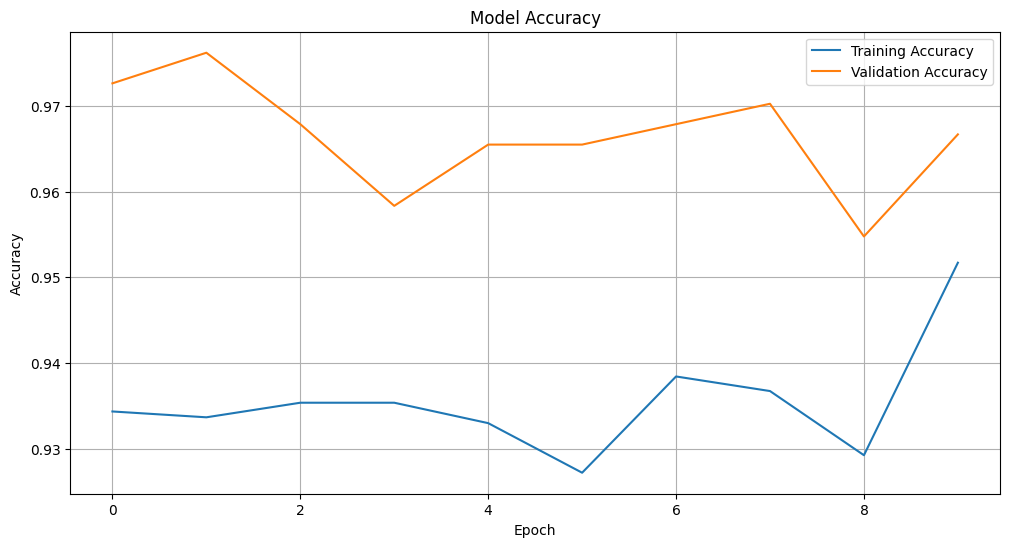

In [19]:
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

1/1 [==============================] - 0s 64ms/step


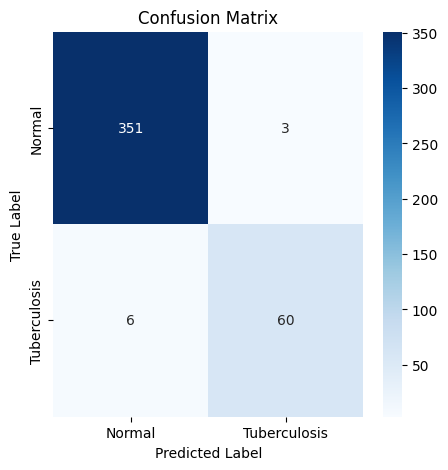

In [20]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Collect true labels and predictions from the test dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=clsname, yticklabels=clsname)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



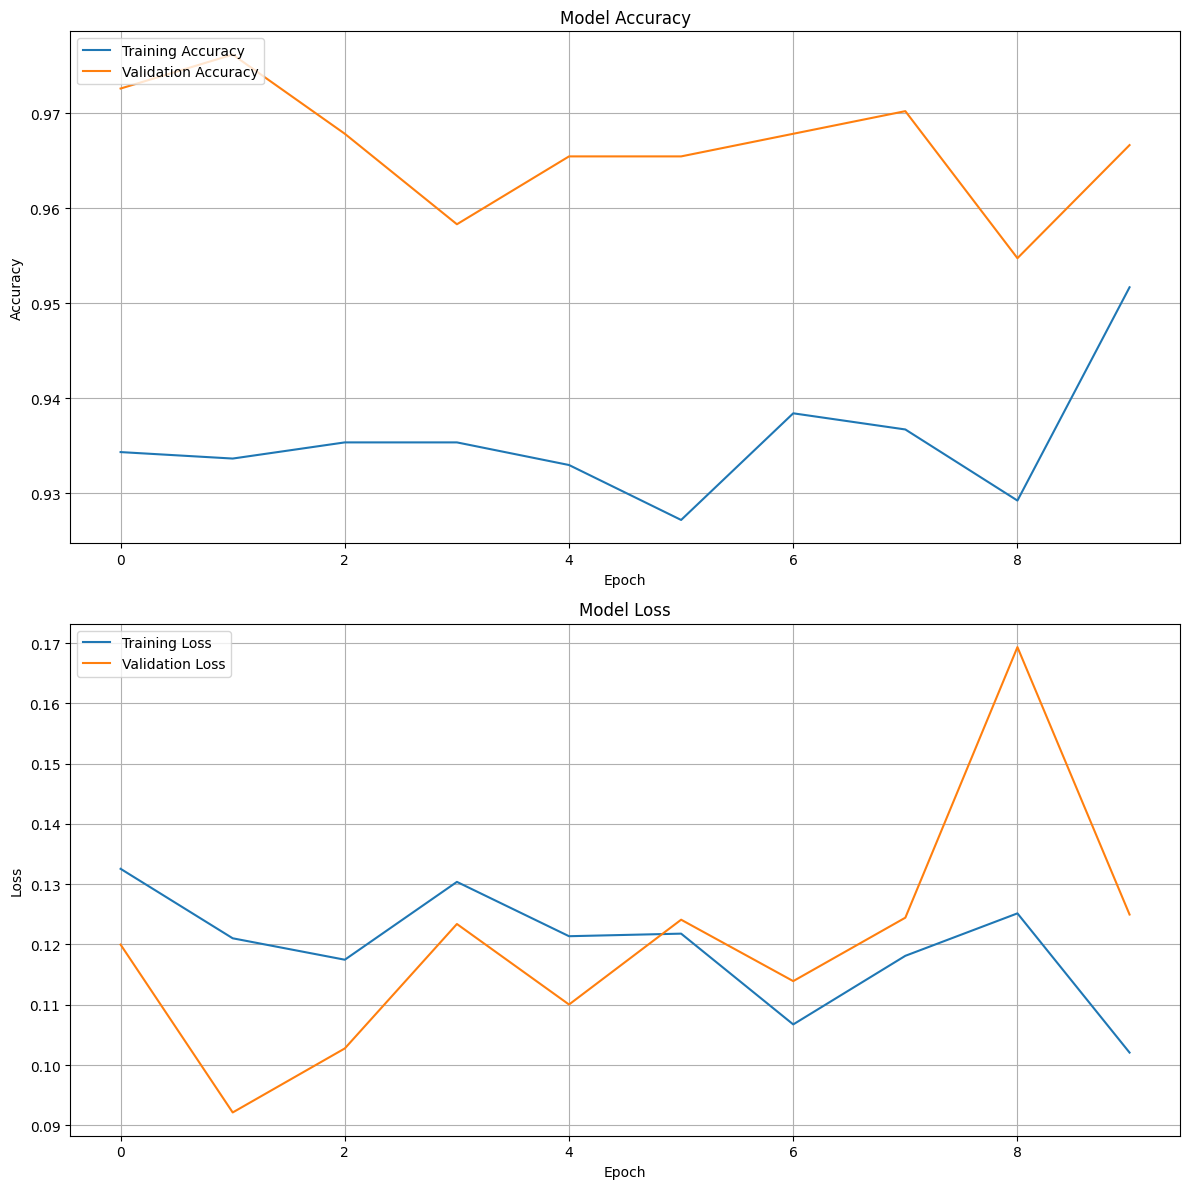

In [21]:
plt.figure(figsize=(12, 12))

# Plot training & validation accuracy
plt.subplot(2, 1, 1)  # First subplot in a 2-row grid
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

# Plot training & validation loss
plt.subplot(2, 1, 2)  # Second subplot in a 2-row grid
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


In [22]:
import numpy as np

def load_and_prepare_image(image_path):
    """Load an image from a file and prepare it for prediction."""
    # Load the image
    img = cv2.imread(image_path)
    # Resize the image to match the input shape of the model
    img = cv2.resize(img, (imgsize, imgsize))
    # Normalize the image
    img = img / 255.0
    # Expand dimensions to create a batch of size 1
    img = np.expand_dims(img, axis=0)
    return img

def predict_tuberculosis(image_path):
    """Predict whether the input image indicates tuberculosis."""
    img = load_and_prepare_image(image_path)
    # Make predictions
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
    return clsname[predicted_class[0]]  # Return the class name

# Path to the new image you want to predict
new_image_path = "C:\\Users\\GOKUL SHANMUGAM\\Downloads\\test.png"
prediction = predict_tuberculosis(new_image_path)
print(f"Prediction: {prediction}")


1/1 [==============================] - 0s 58ms/step
Prediction: Tuberculosis
